# Average forcing into HRUs
We have raw ERA5 and EM-Earth forcing. Here we average those gridded data into HRU-averaged time series, for both the distributed and lumped catchment shapes.

Workflow, per catchment:
- Create forcing grid shapefiles
- Create a remapping csv file using 1 forcing file
- Remap all other forcing files using the remap file

In [1]:
import glob
import shutil
import sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

## Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

## Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

## Processing

In [6]:
debug_message = f'\n!!! CHECK DEBUGGING STATUS: \n- Testing 2 basins\n'

In [7]:
# Set the spacing
era_spacing = 0.25
eme_spacing = 0.10

In [8]:
for ix,row in cs_meta.iterrows():

    # DEBUGGING
    if (ix != 0) and (ix != 9): continue
    
    # Check if we need to run downloads for this station at all
    missing = cs.flow_obs_unavailable(cs_unusable, row.Country, row.Station_id)
    if 'iv' in missing and 'dv' in missing: 
        continue # with next station, because we have no observations at all for this station
    
    # Get shapefile path to determine download coordinates, and forcing destination path
    basin_id, shp_lump_path, shp_dist_path, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder)
    raw_fold, lump_fold, dist_fold = cs.prepare_forcing_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder) # Returns folders only, not file names
    shp_dist_path = Path( str(shp_dist_path).format('basin') )
    print('--- Now running basin {}. {}'.format(ix, basin_id))

    # Ensure we have the CRS set in these shapes, because EASYMORE needs this
    for shp in [shp_lump_path, shp_dist_path]:
        cs.add_crs_to_shapefile(shp)
    
    # Get the forcing files
    eme_merged_files = sorted(glob.glob(str(raw_fold/'EM_Earth_[0-9][0-9][0-9][0-9]-[0-9][0-9].nc')))[0:2] # list
    era_merged_files = sorted(glob.glob(str(raw_fold/'ERA5_[0-9][0-9][0-9][0-9]-[0-9][0-9].nc')))[0:2] # list
    era_invariant = glob.glob(str(raw_fold/'ERA5_*_invariants.nc'))

    # Make forcing shapefiles
    era_grid_shp, eme_grid_shp = cs.prepare_forcing_grid_shapefiles(row.Country, row.Station_id, Path(data_path)/cs_basin_folder)
    for infile, outfile in zip([era_merged_files[0],eme_merged_files[0]], [era_grid_shp,eme_grid_shp]):
        cs.make_forcing_grid_shapefile(infile,outfile)

    # Add geopotential to ERA5 forcing grid shapefile
    cs.add_geopotential_to_era5_grid(era_invariant[0], era_grid_shp)

    # Prepare for remapping
    esmr_temp = cs.prepare_easymore_temp_folder(row.Country, row.Station_id, Path(data_path)/cs_basin_folder)

    # Check if can do the remapping with EASYMORE with files as-is, and act accordingly
    era5_can_remap = cs.check_can_remap_as_is(era_merged_files[0]) # we can assume that if this applies to one file, it applies to all
    if era5_can_remap:
        print('Remapping ERA5')
        era_lump_esmr = cs.easymore_workflow('ERA5', 'lumped', esmr_temp, era_grid_shp, shp_lump_path, lump_fold, era_merged_files)
        era_dist_esmr = cs.easymore_workflow('ERA5', 'dist',   esmr_temp, era_grid_shp, shp_dist_path, dist_fold, era_merged_files)
    else: 
        # Files are 1x1 (lat x lon), use the workflow that adds padding of empty cells around this so we can keep using EASYMORE
        era_lump_esmr = cs.easymore_workflow_with_cell_padding('ERA5', 'lumped', esmr_temp, era_grid_shp, shp_lump_path, lump_fold, 
                                                            era_merged_files, grid_spacing=era_spacing)
        era_dist_esmr = cs.easymore_workflow_with_cell_padding('ERA5', 'dist',   esmr_temp, era_grid_shp, shp_dist_path, dist_fold, 
                                                            era_merged_files, grid_spacing=era_spacing)

    # Repeate for EM-Earth: because EM-Earth has a smaller spacing than ERA5, it is possible that we can remap one but not the other, hence separate
    eme_can_remap = cs.check_can_remap_as_is(eme_merged_files[0]) # we can assume that if this applies to one file, it applies to all
    if eme_can_remap:
        print('Remapping EM-Earth')
        eme_lump_esmr = cs.easymore_workflow('EM-Earth', 'lumped', esmr_temp, eme_grid_shp, shp_lump_path, lump_fold, eme_merged_files)
        eme_dist_esmr = cs.easymore_workflow('EM-Earth', 'dist',   esmr_temp, eme_grid_shp, shp_dist_path, dist_fold, eme_merged_files)
    else:
        eme_lump_esmr = cs.easymore_workflow_with_cell_padding('EM-Earth', 'lumped', esmr_temp, eme_grid_shp, shp_lump_path, lump_fold, 
                                                            eme_merged_files, grid_spacing=eme_spacing)
        eme_dist_esmr = cs.easymore_workflow_with_cell_padding('EM-Earth', 'dist',   esmr_temp, eme_grid_shp, shp_dist_path, dist_fold, 
                                                            eme_merged_files, grid_spacing=eme_spacing)

    # Create a graphical check of what we just did
    fig_file = esmr_temp.parent / f'{row.Country}_{row.Station_id}_spatial_averaging.png'
    cs.era5_eme_easymore_plotting_loop( [era_lump_esmr, era_dist_esmr, eme_lump_esmr, eme_dist_esmr], esmr_temp, fig_file )
            
    # Remove the EASYMORE temp folder
    #shutil.rmtree(esmr_temp)        

--- Now running basin 0. CAN_01AD002
Remapping ERA5
EASYMORE version 1.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only on format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  msdwlwrf  from source file to variable  msdwlwrf  in remapped netCDF file
EASYMORE will remap variable  msnlwrf  from source file to variable  msnlwrf  in remapped netCDF file
EASYMORE will remap variable  msdwswrf  from source file to variable  msdwswrf  in remapped netCDF file
EASYMORE will remap variable  msnswrf  from source file to variable  msnswrf  in remapped netCDF file
EASYMORE will remap variable  mtpr  from source file to variable  mtpr  in remapped netCDF file
EASYMORE will remap variable  sp  from source file to variable  sp  in remapped netCDF file
EASYMORE will remap variable  mper  from source file to variable  mper  in remapped netCDF file
EASYMORE will remap variable  t  from source fil

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:43:16.272423
It took 1.020943 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\raw\ERA5_1950-01.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\lumped/ERA5_lumped_remapped_1950-01-01-00-00-00.nc 
Started at date and time 2023-09-17 16:43:16.293473 
Ended at date and time 2023-09-17 16:44:03.853752 
It took 47.560279 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  msdwlwrf  from source file to variable  msdwlwrf  in remapped netCDF file
EASYMORE will remap variable  msnlwrf  from source file to variable  msnlwrf  in remapped netCDF fi

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:44:49.137798
It took 2.892258 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\raw\ERA5_1950-01.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\distributed/ERA5_dist_remapped_1950-01-01-00-00-00.nc 
Started at date and time 2023-09-17 16:44:49.163747 
Ended at date and time 2023-09-17 16:45:38.461604 
It took 49.297857 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  msdwlwrf  from source file to variable  msdwlwrf  in remapped netCDF file
EASYMORE will remap variable  msnlwrf  from source file to variable  msnlwrf  in remapped netCDF

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:46:23.960201
It took 1.298406 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\raw\EM_Earth_1950-01.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\lumped/EM-Earth_lumped_remapped_1950-01-01-00-00-00.nc 
Started at date and time 2023-09-17 16:46:23.979231 
Ended at date and time 2023-09-17 16:46:28.610683 
It took 4.631452 seconds to finish the remapping of variable(s) 
---------------------
---------------------
EASYMORE version 1.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only on format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  tmean  from source file to variable  tmean  in rem

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:46:32.088477
It took 3.471777 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\raw\EM_Earth_1950-01.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\forcing\distributed/EM-Earth_dist_remapped_1950-01-01-00-00-00.nc 
Started at date and time 2023-09-17 16:46:32.109399 
Ended at date and time 2023-09-17 16:46:36.865394 
It took 4.755995 seconds to finish the remapping of variable(s) 
---------------------
---------------------
--- Now running basin 9. CAN_01AK006
EASYMORE version 1.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only on format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  msdwlwrf  

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:46:41.896429
It took 0.350825 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\TEMP_easymore\ERA5_1966-11.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\lumped/ERA5_lumped_remapped_1966-11-01-00-00-00.nc 
Started at date and time 2023-09-17 16:46:41.914770 
Ended at date and time 2023-09-17 16:47:26.577031 
It took 44.662261 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  msdwlwrf  from source file to variable  msdwlwrf  in remapped netCDF file
EASYMORE will remap variable  msnlwrf  from source file to variable  msnlwrf  in remapped

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:48:12.318005
It took 0.260957 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\TEMP_easymore\ERA5_1966-11.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\distributed/ERA5_dist_remapped_1966-11-01-00-00-00.nc 
Started at date and time 2023-09-17 16:48:12.328943 
Ended at date and time 2023-09-17 16:48:55.812765 
It took 43.483822 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  msdwlwrf  from source file to variable  msdwlwrf  in remapped netCDF file
EASYMORE will remap variable  msnlwrf  from source file to variable  msnlwrf  in remap

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:49:40.460707
It took 0.346612 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\TEMP_easymore\EM_Earth_1966-11.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\lumped/EM-Earth_lumped_remapped_1966-11-01-00-00-00.nc 
Started at date and time 2023-09-17 16:49:40.471547 
Ended at date and time 2023-09-17 16:49:44.879734 
It took 4.408187 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  tmean  from source file to variable  tmean  in remapped netCDF file
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped netC

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Ended at date and time 2023-09-17 16:49:49.782961
It took 0.251132 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\TEMP_easymore\EM_Earth_1966-11.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\distributed/EM-Earth_dist_remapped_1966-11-01-00-00-00.nc 
Started at date and time 2023-09-17 16:49:49.793950 
Ended at date and time 2023-09-17 16:49:54.111983 
It took 4.318033 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  tmean  from source file to variable  tmean  in remapped netCDF file
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped n

### Dev

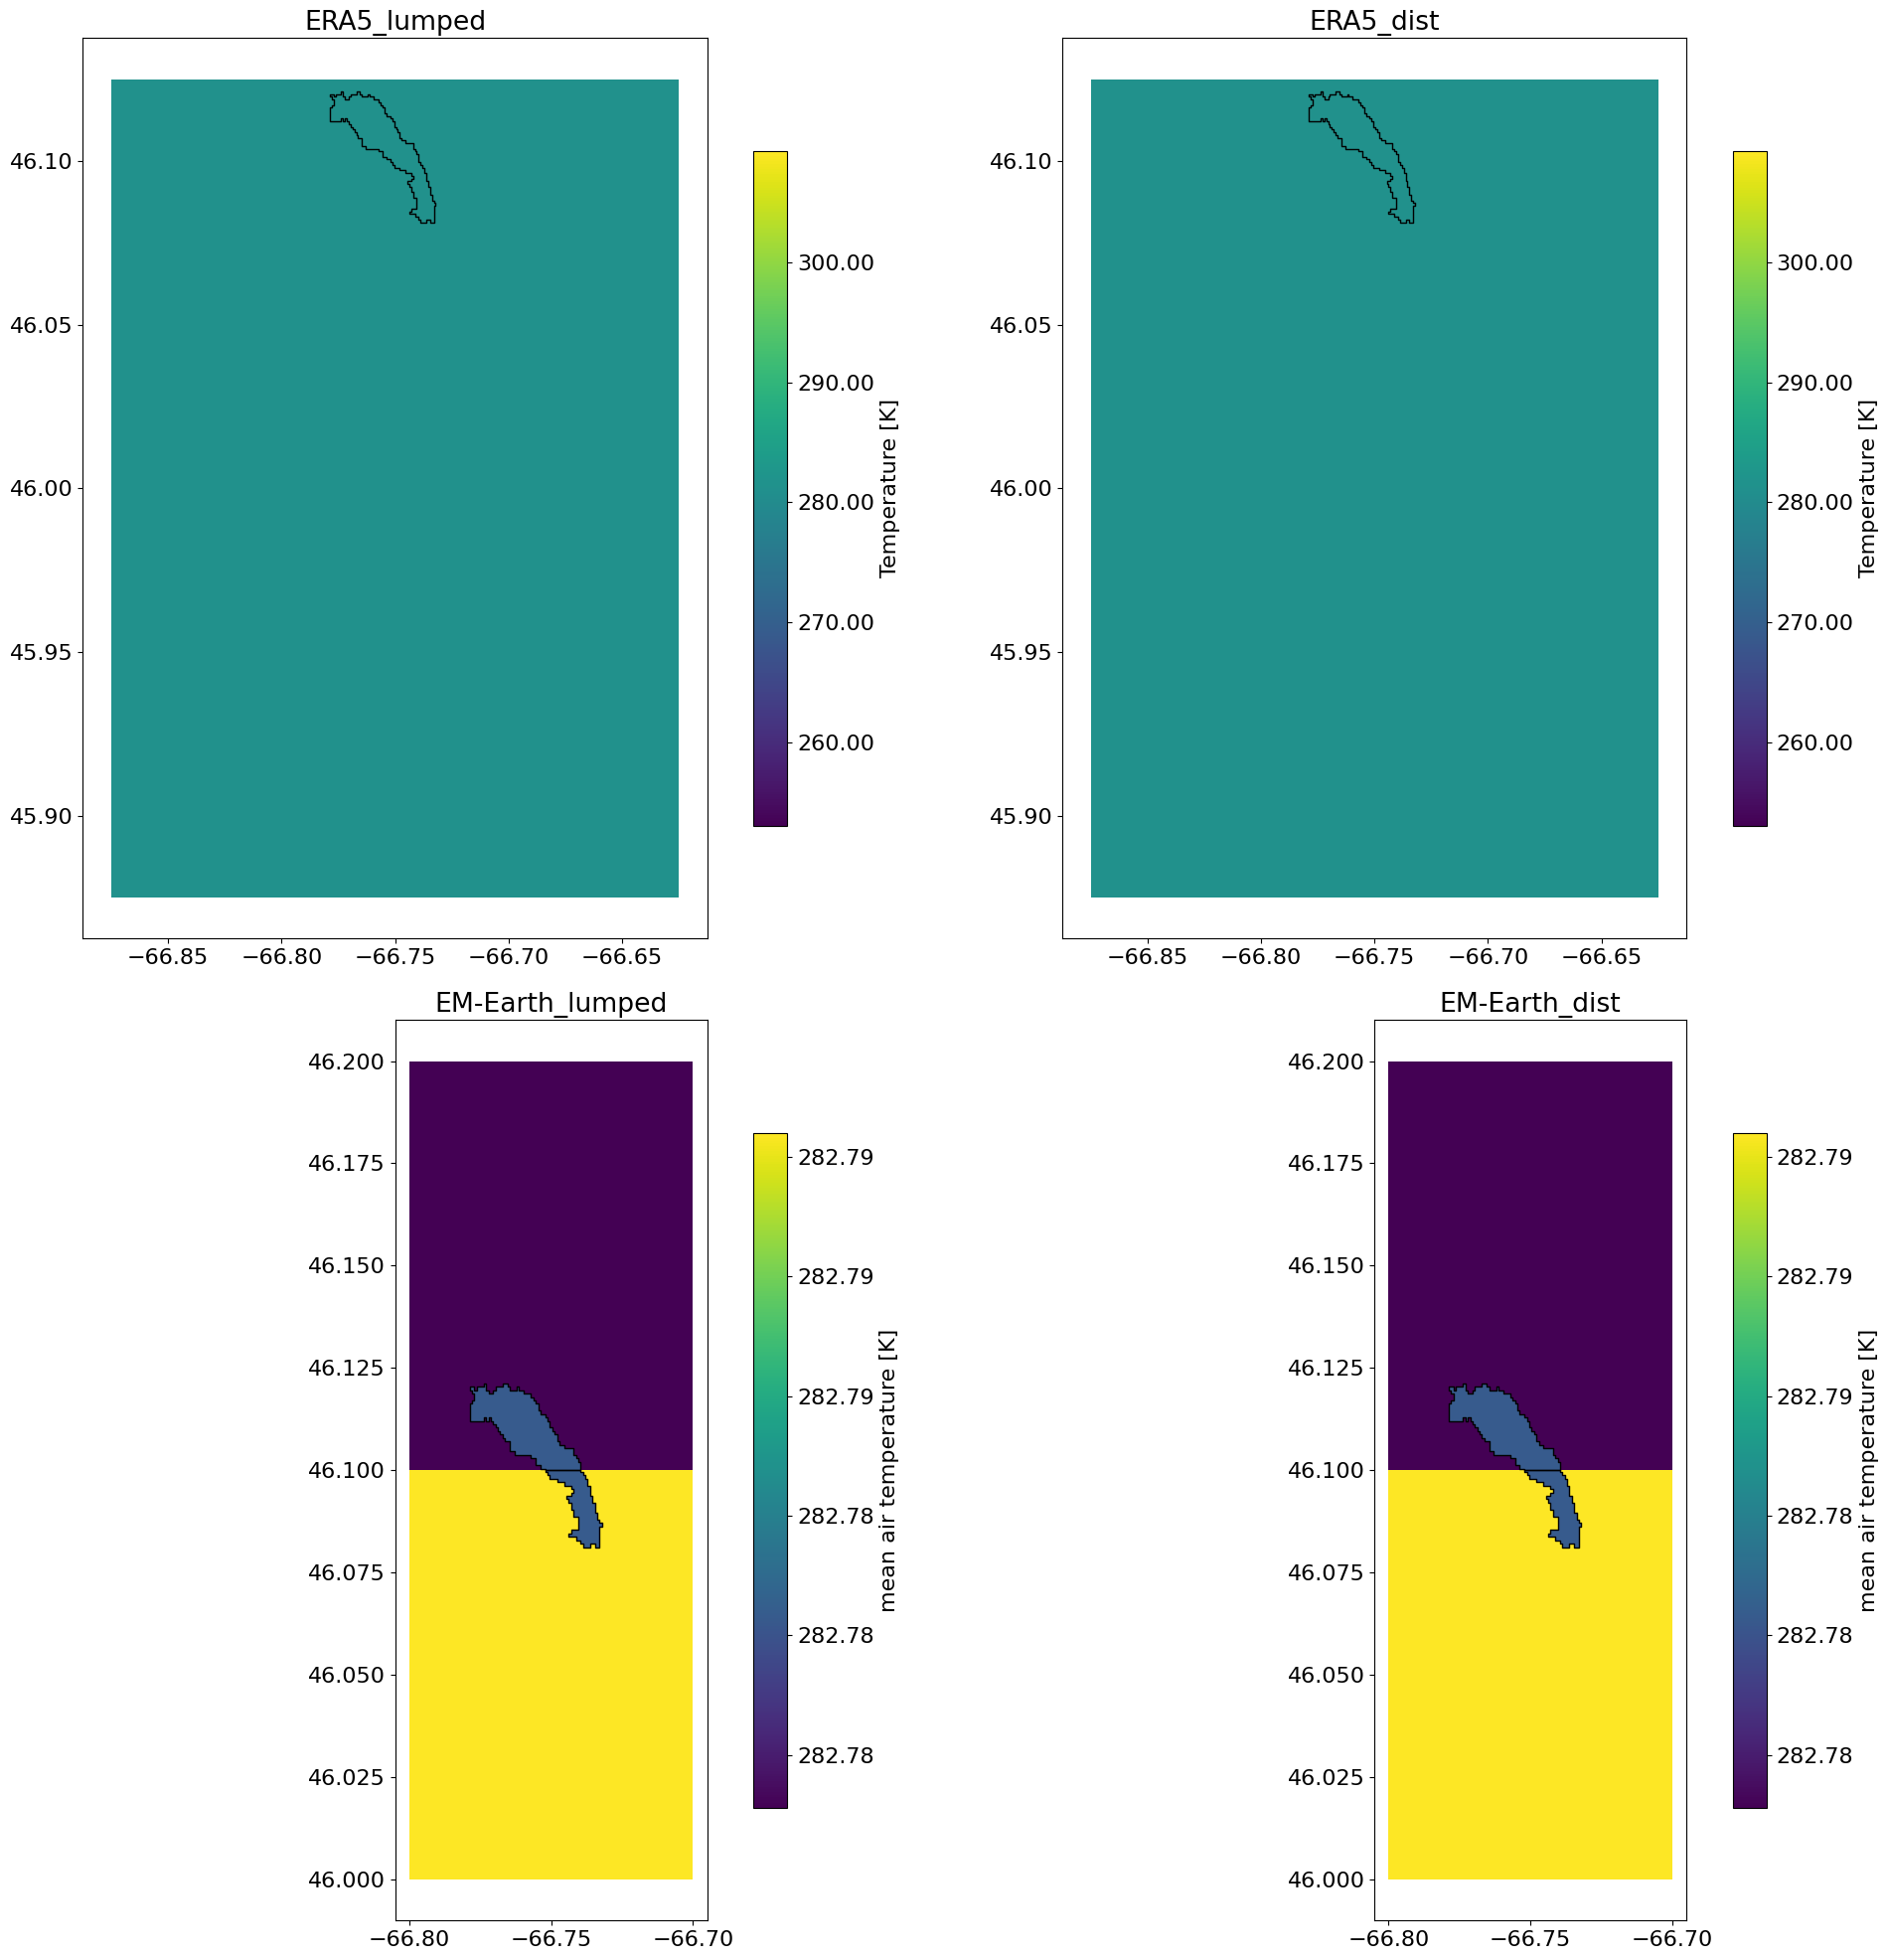

In [143]:
era5_eme_easymore_plotting_loop( [era_lump_esmr, era_dist_esmr, eme_lump_esmr, eme_dist_esmr], esmr_temp, fig_file )

In [139]:
def BACKUP_era5_eme_easymore_plotting_loop(esmr_list, temp_folder, save_here=''):

    '''Loops over ERA5 and EM-Earth EASYMORE objects to plot'''

    fig,axs = plt.subplots(2,2,figsize=(20,20))
    axs = axs.ravel()
    plt.rcParams['font.size'] = 16
    for ix, esmr, plot_var in zip([0,1,2,3],
                                  esmr_list,
                                  ['t','t','tmean','tmean']):
        ax = axs[ix]
        plot_averaging_check(esmr,temp_folder, plot_var, ax=ax)
    plt.tight_layout()
    plt.savefig(save_here, bbox_inches='tight')

In [136]:
def BACKUP_plot_averaging_check(esmr, temp_folder, plot_var, ax='', save_here=''):

    '''Takes an EASYMORE object and plots a summary of results'''

    # Construct the names we don't yet have
    int_name = esmr.temp_dir + esmr.case_name + '_intersected_shapefile.shp'
    yyyy_mm = os.path.basename(esmr.source_nc).split('_')[-1].replace('.nc','')
    out_name = esmr.output_dir + esmr.case_name + '_remapped_' + yyyy_mm + '-01-00-00-00.nc'
    
    # Load the files we need
    int = gpd.read_file(int_name)
    src = gpd.read_file(esmr.target_shp)
    with xr.open_dataset(esmr.source_nc).isel(time=0) as raw, xr.open_dataset(out_name).isel(time=0) as out: # Get a single timestep
    
        # Map new netcdf values onto source shapefile
        out_df = out[[plot_var, esmr.remapped_var_id]].to_dataframe()
        src = src.merge(out_df, left_on=esmr.target_shp_ID, right_on=esmr.remapped_var_id)
    
        # Get plotting min/max values
        vmin = raw[plot_var].min().values
        vmax = raw[plot_var].max().values
        if vmin == vmax:
            vmin *= 0.9
            vmax *= 1.1
    
        # Figure out if we need to handle the case where 'raw' has a spatial dimension of length 1
        raw_flag = False
        if len(raw['latitude']) == 1 or len(raw['longitude']) == 1:
            raw_flag = True
            new_shp = gpd.read_file(esmr.source_shp)
            new_shp[plot_var] = raw[plot_var].values.flatten()
            lbl = f'{raw[plot_var].long_name} [{raw[plot_var].units}]'
            #new_shp,lbl = create_square_geodataframe_from_netcdf(raw,esmr.case_name,plot_var)
        
        # figure
        cb_fmt = '%0.2f'
        if not ax: ax = plt.subplot() # make plotting axis if none was provided
        if raw_flag:
            new_shp.plot(ax=ax, edgecolor='None', column=plot_var, vmin=vmin, vmax=vmax, 
                         legend=True, legend_kwds={'label': lbl, 'orientation': 'vertical', 'shrink': 0.75, 'format': cb_fmt})
        else:
            subplot = raw[plot_var].plot.pcolormesh(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs={'shrink': 0.75, 'format': cg_fmt}) # plot netcdf values
        src.plot(ax=ax, edgecolor='None', column=plot_var, vmin=vmin, vmax=vmax) # plot source shapefile (color=new values)
        int.plot(ax=ax, color='None',edgecolor='k') # plot intersected shapefile (borders only)
        ax.set_title(esmr.case_name)
        if save_here: plt.save_fig(save_here)

#### Small test case

--- Now running basin 9. CAN_01AK006
EASYMORE version 1.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only on format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  tmean  from source file to variable  tmean  in remapped netCDF file
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['time', 'latitude', 'longitude']
EASYMORE detects that the longitude variables has dimensions of:
['longitude']
EASYMORE detects that the latitude variables has dimensions of:
['latitude']
--CREATING-REMAPPING-FILE--
Started at date and time 2023-09-17 10:38:15.682791
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that the field for ID is p

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\easymore\easymore.py:216: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


Remapping C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\TEMP_easymore\EM_Earth_1966-11.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AK006\forcing\lumped/EM-Earth_lumped_remapped_1966-11-01-00-00-00.nc 
Started at date and time 2023-09-17 10:38:15.948504 
Ended at date and time 2023-09-17 10:38:20.078731 
It took 4.130227 seconds to finish the remapping of variable(s) 
---------------------
---------------------
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  tmean  from source file to variable  tmean  in remapped netCDF file
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['time', 'latitude', 'longitude']
EASYMORE detects that

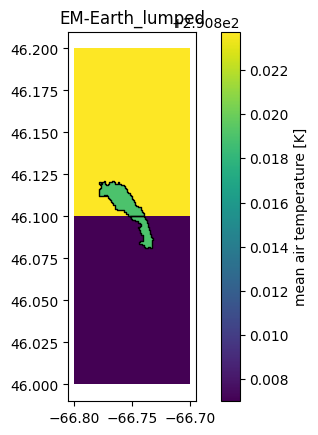

In [14]:
# small area test case
ix = 9
row = cs_meta.iloc[ix]

# Get shapefile path to determine download coordinates, and forcing destination path
basin_id, shp_lump_path, shp_dist_path, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder)
raw_fold, lump_fold, dist_fold = cs.prepare_forcing_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder) # Returns folders only, not file names
shp_dist_path = Path( str(shp_dist_path).format('basin') )
print('--- Now running basin {}. {}'.format(ix, basin_id))

# Ensure we have the CRS set in these shapes, because EASYMORE needs this
for shp in [shp_lump_path, shp_dist_path]:
    cs.add_crs_to_shapefile(shp)

# Get the forcing files
eme_merged_files = sorted(glob.glob(str(raw_fold/'EM_Earth_[0-9][0-9][0-9][0-9]-[0-9][0-9].nc'))) # list
era_merged_files = sorted(glob.glob(str(raw_fold/'ERA5_[0-9][0-9][0-9][0-9]-[0-9][0-9].nc'))) # list
era_invariant = glob.glob(str(raw_fold/'ERA5_*_invariants.nc'))

# Make forcing grid shapefiles
era_grid_shp, eme_grid_shp = cs.prepare_forcing_grid_shapefiles(row.Country, row.Station_id, Path(data_path)/cs_basin_folder)
cs.make_forcing_grid_shapefile(eme_merged_files[0], eme_grid_shp)

# Prepare for remapping
esmr_temp = cs.prepare_easymore_temp_folder(row.Country, row.Station_id, Path(data_path)/cs_basin_folder)

# Check if can do the remapping with EASYMORE with files as-is, and act accordingly
eme_can_remap = cs.check_can_remap_as_is(eme_merged_files[0]) # we can assume that if this applies to one file, it applies to all

# --- Replicate the easymore_workflow_with_cell_padding() internals
esmr = easymore_workflow_with_cell_padding('EM-Earth', 'lumped', esmr_temp, 
                                            eme_grid_shp, shp_lump_path, lump_fold, eme_merged_files, grid_spacing=eme_spacing)

# Make a plot
plot_averaging_check(esmr, esmr_temp, 'tmean', ax='', save_here='')

### Functions

In [8]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import numpy as np
import os

In [9]:
def add_empty_grid_cells_around_single_cell_netcdf(file, 
                                                   grid_spacing=0.25, lat_dim='latitude', lon_dim='longitude', tim_dim='time', 
                                                   to_file=''):

    '''Takes an existing netCDF4 file with latitude and longitude dimensions of size 1, and adds np.nan cells around this'''

    with xr.open_dataset(file) as ds:

        # Get existing latitude and longitude values, and define the extended coordinates
        old_lat = ds[lat_dim].values
        old_lon = ds[lon_dim].values

        # Derive new dimensions from existing ones
        grids_lat = len(old_lat) + 2
        grids_lon = len(old_lon) + 2

        # Make the new coordinates
        new_lat = np.linspace(min(old_lat) - grid_spacing, max(old_lat) + grid_spacing, grids_lat)
        new_lon = np.linspace(min(old_lon) - grid_spacing, max(old_lon) + grid_spacing, grids_lon)
   
        # Create a grid_cells-by-grid_cells-by-time set of NaNs
        new_data = np.empty( (len(ds[tim_dim]), grids_lat, grids_lon) ) # Note that dim order must match what's used below
        new_data[:] = np.nan
    
        # Create a new xarray dataset with the expanded grid and data
        new_ds = xr.Dataset( coords={lon_dim: new_lon, lat_dim: new_lat, tim_dim: ds[tim_dim]})
        for variable in ds.variables:
            if variable not in [lat_dim, lon_dim, tim_dim]:
                new_var = xr.DataArray(new_data, dims=(tim_dim, lat_dim, lon_dim), name=variable) # Note that order of dimensions here must match NaNs above
                new_ds[variable] = new_var.copy() # This copy() is ESSENTIAL - without it, whenever you update the variable values below, you update these values WHEREVER this new_var is inserted in the dataset, i.e., everywhere
                new_ds[variable].attrs = ds[variable].attrs
                new_ds[variable].loc[ {tim_dim: ds[tim_dim], lon_dim: ds[lon_dim], lat_dim: ds[lat_dim]} ] = ds[variable][:] # Copy existing values
                #assert all(new_ds[variable].isel(latitude=1,longitude=1) == ds[variable]), f'{variable} values not correctly copied' # slow
                assert (new_ds[variable].sel(longitude=ds['longitude'], latitude=ds['latitude'], time=ds['time']) - ds[variable]).sum() == 0,\
                    f'{variable} values not correctly copied' # faster

        if to_file:
            new_ds.to_netcdf(to_file)
            return
        else:    
            return new_ds

In [10]:
def easymore_workflow(data, case, esmr_temp, grid_shp, basin_shp, out_folder, infiles):

    ''' Container for repeated tasks needed to run EASYMORE for ERA5 or EM-Earth inputs'''

    # Initiate EASYMORE object
    esmr, remap_file = cs.get_easymore_settings(data, case, grid_shp, basin_shp, esmr_temp, out_folder)

    # Create the remap file
    cs.run_easymore_to_make_remap_file([infiles[0]], [esmr])

    # Update the EASYMORE object now we have remap files
    esmr.remap_csv = str(esmr_temp / remap_file)

    # Remap the remaining files
    for file in infiles[1:]:
        esmr.source_nc = file
        esmr.nc_remapper()

    return esmr # EASYMORE object, containing all info used during run

In [11]:
def easymore_workflow_with_cell_padding(data, case, esmr_temp, grid_shp, basin_shp, out_folder, infiles, grid_spacing=0.25):

    '''Container to add a step to easymore_workflow() where we apply padding to input netCDF file(s)'''
    
    # Initiate EASYMORE object
    esmr, remap_file = cs.get_easymore_settings(data, case, grid_shp, basin_shp, esmr_temp, out_folder)

    # Loop over the files and process
    for ix, file_nc in enumerate(infiles):

        # Pad the input file we're about to use
        temp_nc = str( esmr_temp / os.path.basename(file_nc) )
        if not os.path.isfile(temp_nc): # This lets us skip over making the temporary file if we've already done so for the lumped case; Needed due to weird file closing issues
            add_empty_grid_cells_around_single_cell_netcdf(file_nc, grid_spacing=grid_spacing, to_file=temp_nc)

        # See if we need to do the one-off processing
        if ix == 0:
            
            # Create a new temporary shapefile for the padded netcdf
            temp_shp = str(esmr_temp/'padded.shp')
            cs.make_forcing_grid_shapefile(temp_nc, temp_shp)
            esmr.source_shp = temp_shp

            # Create the remap file
            esmr.source_nc = temp_nc
            esmr.nc_remapper()
            
            # Update the EASYMORE object now we have remap files
            esmr.remap_csv = str(esmr_temp / remap_file)
        
        else:
            esmr.source_nc = temp_nc
            esmr.nc_remapper()

    # Insert the source file into the EASYMORE object for plotting
    esmr.source_nc = file_nc
    esmr.source_shp = grid_shp

    return esmr # EASYMORE object, containing all info used during run

In [12]:
def era5_eme_easymore_plotting_loop(esmr_list, temp_folder, save_here=''):

    '''Loops over ERA5 and EM-Earth EASYMORE objects to plot'''

    fig,axs = plt.subplots(2,2,figsize=(20,20))
    axs = axs.ravel()
    plt.rcParams['font.size'] = 16
    for ix, esmr, plot_var in zip([0,1,2,3],
                                  esmr_list,
                                  ['t','t','tmean','tmean']):
        ax = axs[ix]
        plot_averaging_check(esmr,temp_folder, plot_var, ax=ax)
    plt.tight_layout()
    plt.savefig(save_here, bbox_inches='tight')

In [13]:
def plot_averaging_check(esmr, temp_folder, plot_var, ax='', save_here=''):

    '''Takes an EASYMORE object and plots a summary of results'''

    # Construct the names we don't yet have
    int_name = esmr.temp_dir + esmr.case_name + '_intersected_shapefile.shp'
    yyyy_mm = os.path.basename(esmr.source_nc).split('_')[-1].replace('.nc','')
    out_name = esmr.output_dir + esmr.case_name + '_remapped_' + yyyy_mm + '-01-00-00-00.nc'
    
    # Load the files we need
    int = gpd.read_file(int_name)
    src = gpd.read_file(esmr.target_shp)
    with xr.open_dataset(esmr.source_nc).isel(time=0) as raw, xr.open_dataset(out_name).isel(time=0) as out: # Get a single timestep
    
        # Map new netcdf values onto source shapefile
        out_df = out[[plot_var, esmr.remapped_var_id]].to_dataframe()
        src = src.merge(out_df, left_on=esmr.target_shp_ID, right_on=esmr.remapped_var_id)
    
        # Get plotting min/max values
        vmin = raw[plot_var].min().values
        vmax = raw[plot_var].max().values
        if vmin == vmax:
            vmin *= 0.9
            vmax *= 1.1
    
        # Figure out if we need to handle the case where 'raw' has a spatial dimension of length 1
        raw_flag = False
        if len(raw['latitude']) == 1 or len(raw['longitude']) == 1:
            raw_flag = True
            new_shp = gpd.read_file(esmr.source_shp)
            new_shp[plot_var] = raw[plot_var].values.flatten()
            lbl = f'{raw[plot_var].long_name} [{raw[plot_var].units}]'
            #new_shp,lbl = create_square_geodataframe_from_netcdf(raw,esmr.case_name,plot_var)
        
        # figure
        cb_fmt = '%0.2f'
        if not ax: ax = plt.subplot() # make plotting axis if none was provided
        if raw_flag:
            new_shp.plot(ax=ax, edgecolor='None', column=plot_var, vmin=vmin, vmax=vmax, 
                         legend=True, legend_kwds={'label': lbl, 'orientation': 'vertical', 'shrink': 0.75, 'format': cb_fmt})
        else:
            subplot = raw[plot_var].plot.pcolormesh(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs={'shrink': 0.75, 'format': cg_fmt}) # plot netcdf values
        src.plot(ax=ax, edgecolor='None', column=plot_var, vmin=vmin, vmax=vmax) # plot source shapefile (color=new values)
        int.plot(ax=ax, color='None',edgecolor='k') # plot intersected shapefile (borders only)
        ax.set_title(esmr.case_name)
        if save_here: plt.save_fig(save_here)

# Already in CS functions

In [34]:
def check_remap_need(file, lat_var='latitude', lon_var='longitude'):
    
    '''Opens a netcdf file and checks if latitude and longitude dimensions are larger than 1'''
    
    ds = xr.open_dataset(file)
    needs_remap = False
    if (len(ds[lat_var]) > 1) or (len(ds[lon_var]) > 1): 
        needs_remap = True
    return needs_remap

# Not needed

In [ ]:
def create_square_geodataframe_from_netcdf(file, data, plot_var):

    '''Takes a netcdf with dimensions of size 1 and returns a shapefile for plotting'''

    # Ensure we can return a variable label for the colorbar
    lbl = f'{file[plot_var].long_name} [{file[plot_var].units}]'

    # Get the lat and long values
    lon = file['longitude'].values
    lat = file['latitude'].values

    # Derive spacing from EASYMORE case name
    if 'ERA5' in data:
        spacing = 0.25 # degrees lat/lon
    elif 'EM-Earth' in data:
        spacing = 0.10 # degrees lat/lon

    # We know that for this dataset we only have 1x1 cases (1 lat, 1 lon value), and no 2x1 or 1x2 or similar rectangles
    coordinates = [(lon-spacing/2, lat-spacing/2),
                   (lon+spacing/2, lat-spacing/2), 
                   (lon+spacing/2, lat+spacing/2), 
                   (lon-spacing/2, lat+spacing/2)]
    shp = gpd.GeoDataFrame({plot_var: file[plot_var].values.flatten()}, geometry=[Polygon(coordinates)])

    return shp,lbl